# Using pre-trained network for bone age problem
The goal of this project is to identify the age of a child from an X-ray of their hand. This data was part of a competition http://rsnachallenges.cloudapp.net/competitions/4. We will build a model inspired by the one used by the winners of the competition. We will be using a pretrained network.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [2]:
import cv2
import matplotlib.pyplot as plt 

## Data

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. (If you don't provide a path you will find your data in /home/user/.kaggle/datasets/kmader/rsna-bone-age/ )<br/>
`kaggle datasets download -d kmader/rsna-bone-age -p PATH` <br/>

In [5]:
PATH = Path("/home/yinterian/data/rsna-bone-age/")
list(PATH.iterdir())

[PosixPath('/home/yinterian/data/rsna-bone-age/rsna-bone-age.zip'),
 PosixPath('/home/yinterian/data/rsna-bone-age/boneage-test-dataset.csv'),
 PosixPath('/home/yinterian/data/rsna-bone-age/boneage-training-dataset'),
 PosixPath('/home/yinterian/data/rsna-bone-age/boneage-training-dataset.csv'),
 PosixPath('/home/yinterian/data/rsna-bone-age/boneage-test-dataset')]

In [8]:
! head /home/yinterian/data/rsna-bone-age/boneage-training-dataset.csv

id,boneage,male
1377,180,False
1378,12,False
1379,94,False
1380,120,True
1381,82,False
1382,138,True
1383,150,True
1384,156,True
1385,36,True


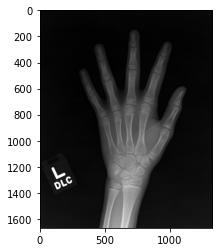

In [9]:
path = PATH/"boneage-training-dataset/9977.png"
im = cv2.imread(str(path))  #.astype(np.float32)/255
plt.imshow(im, cmap='gray')

In [10]:
im = cv2.imread(str(path))  #.astype(np.float32)/255
im.shape

(1668, 1323, 3)

In [11]:
# let's look at the typical size of these images
path = PATH/"boneage-training-dataset"
files = list(path.iterdir())[:200]
dims = [cv2.imread(str(p)).shape for p in files]
dims[:10]

[(1818, 1468, 3),
 (1776, 1412, 3),
 (1935, 1657, 3),
 (1478, 955, 3),
 (1622, 1300, 3),
 (1804, 1303, 3),
 (1526, 1132, 3),
 (2570, 2040, 3),
 (1494, 1104, 3),
 (1673, 1304, 3)]

In [12]:
ratios = [x[0]/x[1] for x in dims]

In [14]:
ratios

[1.2384196185286103,
 1.2577903682719547,
 1.1677730838865419,
 1.5476439790575915,
 1.2476923076923077,
 1.3844973138910208,
 1.3480565371024735,
 1.2598039215686274,
 1.3532608695652173,
 1.2829754601226995,
 1.1046658259773015,
 1.1648745519713262,
 1.333969465648855,
 1.2904761904761906,
 1.7433439829605963,
 1.2358356940509916,
 1.1615384615384616,
 1.6679920477137178,
 1.2598039215686274,
 1.1229395604395604,
 1.3138766519823788,
 1.4817733990147783,
 1.4007187780772687,
 1.3852534562211982,
 1.2666666666666666,
 1.59140625,
 1.2333333333333334,
 0.9567126725219574,
 1.3507194244604317,
 1.2991202346041055,
 1.3265957446808512,
 1.105421686746988,
 1.3178893178893178,
 1.3096590909090908,
 1.4436229205175601,
 1.0,
 1.3960612691466083,
 1.343046357615894,
 1.298531810766721,
 1.2586206896551724,
 1.2260479041916168,
 1.3777589134125636,
 1.0116518163125428,
 1.3488745980707395,
 1.4834008097165992,
 1.2581120943952802,
 1.4065281899109792,
 1.2022727272727274,
 1.531686358754028,

Here is a presentation with EDA on this data
https://alxndrkalinin.github.io/pdf/2017-12_CFT_BoneAge.pdf

## Data augmentation
The winners of the competition used real-time image augmentation consisting of horizontal/vertical translation, zoom, and rotation of 20 percent/degrees as well as horizontal flip. They used 500x500 images.

In [13]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Center crop

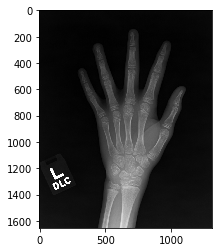

In [10]:
path = PATH/"boneage-training-dataset/9977.png"
im = cv2.imread(str(path))
im = center_crop(im)
plt.imshow(im, cmap='gray')

### Resize, horizontal and vertical translations

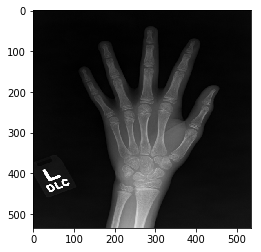

In [11]:
# resize desforms the image a bit
# note that by resizing to a larger number and random cropping we are doing horizontal and vertical translations
# we should try just center cropping the image instead of resizing
im = cv2.resize(im, (550, 550))
im = random_crop(im)
plt.imshow(im, cmap='gray')

### Random Rotation (-10, 10) 

8.89695745715943


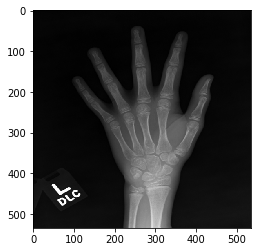

In [12]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot, cmap='gray')

### Horizontal Flip

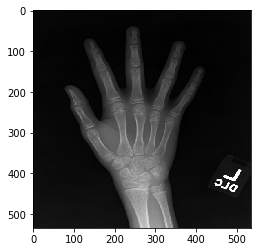

In [13]:
im_f = np.fliplr(im)
plt.imshow(im_f, cmap='gray')

## Split train and validation

In [15]:
df = pd.read_csv(PATH/"boneage-training-dataset.csv")
train = df.sample(frac=0.8, random_state=3).copy()
valid = df.drop(train.index).copy()

In [16]:
a = train.head()

In [17]:
row = a.iloc[0]
b = (1 if row["male"] == True else 0)
b

1

In [18]:
b = int(row["male"] == True)
b

1

## Saving a resized dataset

In [19]:
# Do this to save time at training.
PATH_300 = PATH/"boneage-300"
#PATH_300.mkdir()

In [20]:
def get_a_crop(path, sz=300):
    im = cv2.imread(str(path))
    r,c,_ = im.shape
    pad = abs(r-c)//4
    if r > c :
        im2 = cv2.copyMakeBorder(im, 0, 0, pad, pad, cv2.BORDER_REFLECT)
    else:
        im2 = cv2.copyMakeBorder(im, pad, pad, 0, 0, cv2.BORDER_REFLECT)
    return cv2.resize(center_crop(im2), (sz, sz))

In [21]:
from os import listdir
from os.path import join
def resize_all_images():
    for f in listdir(PATH/"boneage-training-dataset/"):
        old_path = join(PATH/"boneage-training-dataset/", f)
        new_path = join(PATH/"boneage-300/", f)
        img2 = get_a_crop(old_path)
        cv2.imwrite(new_path, img2)

In [ ]:
resize_all_images()

## Dataset

In [22]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

class BoneAgeDataset(Dataset):
    def __init__(self, df, transforms=True, sz=300):
        self.path_to_images = PATH/"boneage-300/"
        self.transforms = transforms
        self.df = df
        self.sz = sz
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = str(self.path_to_images) + "/" + str(row["id"]) + ".png"
        y = row["boneage"]
        x2 = int(row["male"] == True)
        x = cv2.imread(str(path)).astype(np.float32)/255
        if self.transforms:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            x = random_crop(x)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
        else:
            x = center_crop(x)
        x = normalize(x)
        return np.rollaxis(x, 2), x2, y[None]

In [23]:
train_ds = BoneAgeDataset(train)
valid_ds = BoneAgeDataset(valid, transforms=False)

In [24]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [25]:
# run this multiple times to get different images
x1, x2, y = train_ds[10]
#plt.imshow(np.rollaxis(x1, 2), cmap='gray')

In [26]:
x1.shape, x2, y

((3, 284, 284), 1, array([216]))

## Model

In [27]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet50(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.linear = nn.Sequential(nn.Linear(1, 32), nn.Dropout(0.5))
        self.classifier = nn.Sequential(nn.BatchNorm1d(2048 + 32), nn.Linear(2048 + 32, 1))

    def forward(self, x1, x2):
        x1 = self.features1(x1)
        x1 = self.features2(x1)
        x1 = F.relu(x1)
        x1 = nn.AdaptiveAvgPool2d((1,1))(x1)
        x1 = x1.view(x1.shape[0], -1)
        x2 = self.linear(x2)
        x = torch.cat([x1, x2], 1)
        x = self.classifier(x)
        return x

In [28]:
model = Net().cuda()

In [29]:
x1, x2, y = next(iter(train_dl))

In [30]:
x1 = x1.cuda().float()
x2 = x2.cuda().float()
y =  y.cuda().float()

In [31]:
x1.shape, x2.unsqueeze(1).shape, y.shape

(torch.Size([16, 3, 284, 284]), torch.Size([16, 1]), torch.Size([16, 1]))

In [32]:
y_hat = model(x1, x2.unsqueeze(1))

In [33]:
# F.l1_loss note that this is a regression problem
F.l1_loss(y_hat, y).item()

130.55014038085938

## Learning rate finder

In [28]:
def create_optimizer(model, lr0):
    params = [{'params': model.features1.parameters(), 'lr': lr0/9},
              {'params': model.features2.parameters(), 'lr': lr0/3},
              {'params': model.linear.parameters(), 'lr': lr0},
              {'params': model.classifier.parameters(), 'lr': lr0}]
    return optim.Adam(params, weight_decay=1e-5)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [29]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    optimizer = create_optimizer(model, lrs[0])
    model.train()
    ind = 0
    for i in range(epochs):
        for x1, x2, y in train_dl:
            lr = lrs[ind]
            update_optimizer(optimizer, [lr/9, lr/3, lr, lr])
            x1 = x1.cuda().float()
            x2 = x2.cuda().unsqueeze(1).float()
            y = y.cuda().float()
            out = model(x1, x2)
            loss = F.l1_loss(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses 

In [36]:
model = Net().cuda()
lrs, losses = LR_range_finder(model, train_dl)

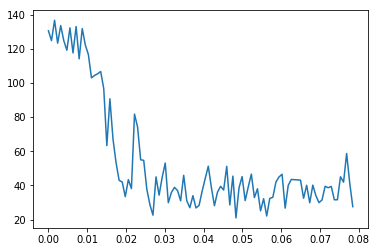

In [38]:
plt.plot(lrs[:100], losses[:100])
plt.show()

## Training with one-cycle 

In [30]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

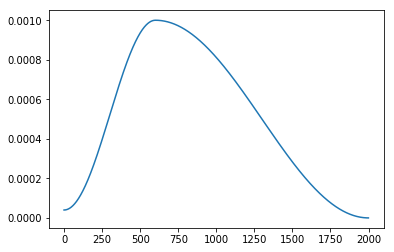

In [31]:
N = 2000
lr = get_cosine_triangular_lr(0.001, N)
plt.plot(list(range(N)), lr)
plt.show()

In [32]:
def train_one_epoch(model, optimizer, train_dl, lrs, idx):
    model.train()
    total = 0
    sum_loss = 0
    for x1, x2, y in train_dl:
        lr = lrs[idx]
        update_optimizer(optimizer, [lr/9, lr/3, lr, lr])
        batch = y.shape[0]
        x1 = x1.cuda().float()
        x2 = x2.cuda().unsqueeze(1).float()
        y = y.cuda().float()
        out = model(x1, x2)
        loss = F.l1_loss(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        idx += 1
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total, idx

In [39]:
def train_triangular_policy(model, train_dl, valid_dl, max_lr=0.04, epochs = 5):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_loss = 10000.0
    for i in range(epochs):
        train_loss, idx = train_one_epoch(model, optimizer, train_dl, lrs, idx)
        val_loss = val_metric(model, valid_dl)
        print("train_loss %.3f val_loss %.3f" % (train_loss, val_loss))
        if val_loss < prev_val_loss: 
            prev_val_loss = val_loss
            path = "{0}/models/model_resnet50_{1:.0f}.pth".format(PATH, 100*val_loss)
            if val_loss < 9:
                save_model(model, path)
                print(path)

In [34]:
def val_metric(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    for x1, x2, y in valid_dl:
        batch = y.shape[0]
        x1 = x1.cuda().float()
        x2 = x2.unsqueeze(1).cuda().float()
        y = y.cuda().float()
        out = model(x1, x2)
        loss = F.l1_loss(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    return sum_loss/total

## Training with triangular rates

In [35]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [36]:
model = Net().cuda()

In [37]:
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.02, epochs = 10)

train_loss 54.448 val_loss 19.537
train_loss 15.088 val_loss 17.631
train_loss 15.503 val_loss 32.269
train_loss 14.664 val_loss 13.798
train_loss 13.643 val_loss 13.665
train_loss 12.876 val_loss 10.078
train_loss 12.340 val_loss 10.829
train_loss 11.265 val_loss 8.896
/data2/yinterian/rsna-bone-age/models/model_resnet34_890.pth
train_loss 10.632 val_loss 9.774
train_loss 10.225 val_loss 8.882
/data2/yinterian/rsna-bone-age/models/model_resnet34_888.pth


In [40]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.02, epochs = 25)

train_loss 61.511 val_loss 28.676
train_loss 13.096 val_loss 10.517
train_loss 13.218 val_loss 40.226
train_loss 13.807 val_loss 19.968
train_loss 14.011 val_loss 21.753
train_loss 14.117 val_loss 27.690
train_loss 14.144 val_loss 24.050
train_loss 13.947 val_loss 12.409
train_loss 13.444 val_loss 13.542
train_loss 13.230 val_loss 11.519
train_loss 12.894 val_loss 14.088
train_loss 12.609 val_loss 9.447
train_loss 12.002 val_loss 10.391
train_loss 11.614 val_loss 9.865
train_loss 11.303 val_loss 9.069
train_loss 10.985 val_loss 8.805
/data2/yinterian/rsna-bone-age/models/model_resnet50_880.pth
train_loss 10.769 val_loss 8.939
train_loss 10.619 val_loss 8.874
train_loss 10.382 val_loss 9.976
train_loss 10.241 val_loss 9.445
train_loss 9.982 val_loss 10.096
train_loss 9.874 val_loss 9.223
train_loss 9.683 val_loss 8.258
/data2/yinterian/rsna-bone-age/models/model_resnet50_826.pth
train_loss 9.569 val_loss 8.176
/data2/yinterian/rsna-bone-age/models/model_resnet50_818.pth
train_loss 9.465

In [41]:
model = Net().cuda()
train_triangular_policy(model, train_dl, valid_dl, max_lr=0.03, epochs = 25)

train_loss 48.814 val_loss 13.796
train_loss 13.371 val_loss 54.238
train_loss 14.337 val_loss 29.328
train_loss 14.783 val_loss 36.535
train_loss 15.039 val_loss 22.722
train_loss 14.766 val_loss 24.082
train_loss 14.962 val_loss 20.883
train_loss 13.905 val_loss 21.981
train_loss 13.624 val_loss 20.101
train_loss 13.166 val_loss 12.395
train_loss 12.656 val_loss 12.214
train_loss 12.244 val_loss 10.165
train_loss 11.878 val_loss 11.051
train_loss 11.575 val_loss 12.046
train_loss 11.420 val_loss 9.462
train_loss 11.151 val_loss 9.167
train_loss 10.924 val_loss 9.430
train_loss 10.779 val_loss 9.382
train_loss 10.555 val_loss 8.253
/data2/yinterian/rsna-bone-age/models/model_resnet50_825.pth
train_loss 10.295 val_loss 8.943
train_loss 10.201 val_loss 10.025
train_loss 9.973 val_loss 9.162
train_loss 9.803 val_loss 8.704
train_loss 9.642 val_loss 8.473
train_loss 9.582 val_loss 8.491


# References

* https://www.16bit.ai/blog/ml-and-future-of-radiology
* https://stanfordmedicine.app.box.com/s/vhq1zop1867gr9rwnan4byj8lfxue173
* https://github.com/fastai/fastai/blob/master/courses/dl2/cifar10-darknet.ipynb